<a href="https://colab.research.google.com/github/WaruCodes/Deep_Learning-Defect-prediction-framework-using-CodeBERT-and-GAT/blob/main/Final_Model_Black_Repository.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/black_only/train_black.csv")
val_df   = pd.read_csv("/content/drive/MyDrive/black_only/val_black.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/black_only/test_black.csv")


In [ ]:
train_data = train_df.to_dict(orient="records")
val_data   = val_df.to_dict(orient="records")
test_data  = test_df.to_dict(orient="records")


In [ ]:
# Colab/Notebook setup
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip -q install transformers==4.41.0 torchmetrics==1.4.0 scikit-learn==1.6.0 tree_sitter==0.20.2 tree_sitter_languages transformers torch
!pip -q install torch_geometric==2.6.0 torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu118.html
!pip -q install tree_sitter==0.20.2

import os, sys, json, math, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from torchmetrics.functional import auroc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


# Data Loading and Preprocessing
Goal: Read your dataset rows, decode  as UTF‑8 (fixed file after commit), preserve exact line boundaries (including whitespace), and build labels from .

Line numbering: This notebook assumes  uses 0-based indices. If yours are 1-based, subtract 1 during preprocessing.

Commit/diff metadata: Optional functions are included to enrich samples later

In [ ]:
import json
import pandas as pd
import random

DATASET_PATH = "/content/drive/MyDrive/black_only/train_black.csv"

df_raw = pd.read_csv(DATASET_PATH)
print("Total rows (files):", len(df_raw))
print("Columns:", df_raw.columns.tolist())

Total rows (files): 500
Columns: ['datetime', 'commit', 'repo', 'filepath', 'content', 'methods', 'induce_bug']


In [ ]:
import json


def normalize_content(raw):
    """
    Decode content safely while preserving exact line structure.
    Do NOT modify escape sequences or newline layout.
    """
    if isinstance(raw, (bytes, bytearray)):
        content = raw.decode("utf-8", errors="replace")
    else:
        content = str(raw)

    # Fix escaped newlines ONLY if present
    if "\\n" in content:
        content = content.replace("\\n", "\n") # Use direct replacement for \n ->

    return content


def split_with_line_numbers(raw):
    """
    Returns list of (line_number, line_text) tuples
    preserving exact original line numbers.
    """
    text = normalize_content(raw)

    # keepends=True ensures no line shifting
    lines = text.splitlines(keepends=True)

    return [(idx, line) for idx, line in enumerate(lines, start=1)]


def parse_induce_bug(value):
    """
    Parse induce_bug into a list of unique 1-based integer line numbers.
    """
    if isinstance(value, list):
        return sorted({
            int(v) for v in value
            if str(v).strip().lstrip("-").isdigit()
        })

    if isinstance(value, (bytes, bytearray)):
        value = value.decode("utf-8", errors="replace")

    if isinstance(value, str):
        value = value.strip()

        # Try JSON list
        try:
            parsed = json.loads(value)
            if isinstance(parsed, list):
                return sorted({
                    int(v) for v in parsed
                    if str(v).strip().lstrip("-").isdigit()
                })
        except Exception:
            pass

        # Fallback: comma/space separated
        value = value.strip("[]")
        tokens = value.replace(",", " ").split()

        return sorted({
            int(v) for v in tokens
            if v.strip().lstrip("-").isdigit()
        })

    return []

def preprocess_df(df):
    df = df.copy()

    # Drop rows without content
    df = df.dropna(subset=["content"]).reset_index(drop=True)

    # Normalize content
    df["content"] = df["content"].apply(normalize_content)

    # Parse induce_bug
    df["induce_bug"] = df["induce_bug"].apply(parse_induce_bug)

    # Keep only rows where induce_bug is not empty
    df = df[df["induce_bug"].apply(len) > 0].reset_index(drop=True)

    return df


def df_row_to_record(row):
    return {
        "datetime": row.get("datetime", ""),
        "committer": row.get("committer", ""),
        "commit": row.get("commit", ""),
        "repo": row.get("repo", ""),
        "filepath": row.get("filepath", ""),
        "content": row["content"],
        "induce_bug": row["induce_bug"],
    }

In [ ]:
df = preprocess_df(df_raw)

print("After preprocessing:")
print("Files with buggy lines:", len(df))

After preprocessing:
Files with buggy lines: 221


In [ ]:
def extract_buggy_lines(record, max_lines=5):
    """
    Extract buggy lines using 0-based induce_bug indexing.
    """
    numbered_lines = split_with_line_numbers(record["content"])

    bug_map = []
    for idx, (line_no, text) in enumerate(numbered_lines):
        if idx in record["induce_bug"]:   # 0-based match
            bug_map.append((idx, text.rstrip("\n")))

    return bug_map[:max_lines]

In [ ]:
record = df_row_to_record(df_clean.iloc[0])
lines = split_with_line_numbers(record["content"])

for ln in record["induce_bug"]:
    print("Expected buggy line:", ln)
    print("Actual content:")
    print(repr(lines[ln][1]))   # ln-1 because list is 0-based
    print("-" * 40)

Expected buggy line: 229
Actual content:
'            docstring = normalize_string_prefix(leaf.value, self.remove_u_prefix)\n'
----------------------------------------
Expected buggy line: 230
Actual content:
'            prefix = get_string_prefix(docstring)\n'
----------------------------------------
Expected buggy line: 231
Actual content:
'            docstring = docstring[len(prefix) :]  # Remove the prefix\n'
----------------------------------------


In [ ]:
ln = record["induce_bug"][0]

print("Using ln-1:")
print(repr(lines[ln-1][1]))

print("\nUsing ln:")
print(repr(lines[ln][1]))

Using ln-1:
'            # indentation of those changes the AST representation of the code.\n'

Using ln:
'            docstring = normalize_string_prefix(leaf.value, self.remove_u_prefix)\n'


In [ ]:
NUM_SAMPLES = 221

for i in range(NUM_SAMPLES):
    row = df_clean.iloc[i]
    record = df_row_to_record(row)

    print("\n" + "=" * 80)
    print("FILE:", record["filepath"])
    print("BUGGY LINE INDICES (0-based):", record["induce_bug"])

    buggy_lines = extract_buggy_lines(record)

    print("\nExtracted buggy lines:")
    for line_no, code in buggy_lines:
        print(f"[Line {line_no}] {code}")


FILE: src\black\linegen.py
BUGGY LINE INDICES (0-based): [229, 230, 231]

Extracted buggy lines:
[Line 229]             docstring = normalize_string_prefix(leaf.value, self.remove_u_prefix)
[Line 230]             prefix = get_string_prefix(docstring)
[Line 231]             docstring = docstring[len(prefix) :]  # Remove the prefix

FILE: src\black\strings.py
BUGGY LINE INDICES (0-based): [90]

Extracted buggy lines:
[Line 90]         prefix += string[prefix_idx]

FILE: src\black\trans.py
BUGGY LINE INDICES (0-based): [414, 434, 544, 1039, 1293]

Extracted buggy lines:
[Line 414]             and LL[next_str_idx].type == token.STRING
[Line 434] 
[Line 544] 
[Line 1039]         insert_str_child = insert_str_child_factory(LL[string_idx])
[Line 1293]             yield from _fexpr_slices

FILE: black.py
BUGGY LINE INDICES (0-based): [5, 125, 126, 127, 128, 129, 130, 225, 226, 227, 228, 229, 242, 255, 274, 287, 293, 302, 306, 317, 331, 352, 378, 386, 394, 395, 400, 426, 437, 457, 468, 474, 47

In [ ]:
#Turn the preprocessing in to reusable pipeline

def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Loaded {csv_path}: {len(df)} rows")

    df = preprocess_df(df)
    print(f"After preprocessing: {len(df)} rows")

    return df


In [ ]:
#All splits using same pipeline

train_df = load_and_preprocess("/content/drive/MyDrive/black_only/train_black.csv")
val_df   = load_and_preprocess("/content/drive/MyDrive/black_only/val_black.csv")
test_df  = load_and_preprocess("/content/drive/MyDrive/black_only/test_black.csv")


NameError: name 'pd' is not defined

In [ ]:
#Covert data frames in to records

def df_to_records(df):
    return [df_row_to_record(row) for _, row in df.iterrows()]

train_records = df_to_records(train_df)
val_records   = df_to_records(val_df)
test_records  = df_to_records(test_df)


NameError: name 'train_df' is not defined

In [ ]:
#Bug statics per splits

def print_stats(name, records):
    buggy = sum(len(r["induce_bug"]) > 0 for r in records)
    print(f"{name}: {len(records)} files | {buggy} buggy")

print_stats("Train", train_records)
print_stats("Val", val_records)
print_stats("Test", test_records)


NameError: name 'train_records' is not defined

# Line tokenization and CodeBERT embeddings
Keep whitespace: We never strip or trim lines. We split by  exactly to preserve  alignment.
Embedding strategy: Use CodeBERT’s [CLS] embedding per line. Then contextualize with BiLSTM across lines to capture neighbors.

In [ ]:
# CodeBERT
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
codebert.eval()

@torch.no_grad()
def embed_lines_with_codebert(lines, max_len=128):
    # Returns tensor [L, 768]; preserves line indices and whitespace alignment
    embs = []
    for line in lines:
        tokens = tokenizer.encode(line, truncation=True, max_length=max_len)
        input_ids = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)
        outputs = codebert(input_ids)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [1, 768]
        embs.append(cls_emb.squeeze(0))
    return torch.stack(embs, dim=0)

# BiLSTM contextualizer
class ContextEncoder(nn.Module):
    def __init__(self, in_dim=768, hidden=256, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.proj = nn.Linear(hidden*2, hidden*2)
        self.norm = nn.LayerNorm(hidden*2)

    def forward(self, x):  # x: [B, L, 768]
        h, _ = self.lstm(x)
        y = self.norm(torch.tanh(self.proj(h)))  # [B, L, 512]
        return y

context_encoder = ContextEncoder().to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


# Graph construction: AST + CFG-lite + PDG-lite → CPG
AST: Tree-sitter Python grammar to gather node spans. We link consecutive lines inside the same span.

CFG-lite: Simple sequential edges line i ↔ i+1. This keeps the graph sparse and Colab-friendly.

PDG-lite: Connect lines that share identifier names (excluding Python keywords), within a local window.

In [ ]:

!pip install tree-sitter tree-sitter-languages
!pip install torch
from tree_sitter import Language, Parser
from tree_sitter_languages import get_language
import torch


# Build Python grammar

from tree_sitter import Parser

PY_LANGUAGE = get_language("python")

parser = Parser()
parser.set_language(PY_LANGUAGE)


def parse_ast_spans(code):
    tree = parser.parse(code.encode("utf8"))
    root = tree.root_node
    spans = []

    def visit(node):
        spans.append((node.type, node.start_point[0], node.end_point[0]))  # 0-based lines
        for child in node.children:
            visit(child)

    visit(root)
    return spans


def extract_identifiers_python(line):
    tokens = [t for t in ''.join([c if (c.isalnum() or c=='_') else ' ' for c in line]).split() if len(t) > 1]
    stop = set([
        "def","class","return","if","else","elif","for","while","import","from","as","with",
        "try","except","finally","True","False","None","and","or","not","in","is","lambda",
        "global","nonlocal","assert","yield","pass","break","continue","raise"
    ])
    return [t for t in tokens if t not in stop]

def build_cpg(lines, max_window=15):
    num_lines = len(lines)
    edge_index = []
    edge_type = []  # 0=sequential, 1=AST-span adjacency, 2=def-use PDG-lite

    # CFG-lite: sequential edges
    for i in range(num_lines-1):
        edge_index.append([i, i+1]); edge_type.append(0)
        edge_index.append([i+1, i]); edge_type.append(0)

    # AST-lite: adjacency inside span ranges
    code = "\n".join(lines)
    spans = parse_ast_spans(code)
    for tp, s, e in spans:
        s = max(0, min(s, num_lines-1))
        e = max(0, min(e, num_lines-1))
        for i in range(s, e):
            edge_index.append([i, i+1]); edge_type.append(1)
            edge_index.append([i+1, i]); edge_type.append(1)

    # PDG-lite: co-occurrence window edges for identifiers
    id_map = {}
    for i, line in enumerate(lines):
        ids = extract_identifiers_python(line)
        for tok in ids:
            id_map.setdefault(tok, []).append(i)
    for tok, idxs in id_map.items():
        idxs = sorted(set(idxs))
        for a in idxs:
            for b in idxs:
                if a != b and abs(a-b) <= max_window:
                    edge_index.append([a, b]); edge_type.append(2)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2,0), dtype=torch.long)
    edge_type = torch.tensor(edge_type, dtype=torch.long) if edge_type else torch.empty((0,), dtype=torch.long)
    return edge_index, edge_type

# Dataset class
Function: Turn each record into a graph sample:

CodeBERT embeddings → BiLSTM contextualization → node features

Build CPG-lite edges

Prepare line labels from  (exact indices preserved)

File label for the file-level head

In [ ]:
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Dataset wrapper (unchanged)
# -----------------------------
class LineGraphSample:
    def __init__(self, x, edge_index, edge_type, line_labels, file_label, mask_lines):
        self.x = x
        self.edge_index = edge_index
        self.edge_type = edge_type
        self.line_labels = line_labels
        self.file_label = file_label
        self.mask_lines = mask_lines


class DefectDataset(Dataset):
    def __init__(self, records, cache=True):
        self.records = records
        self.cache = cache
        self._cache = [None] * len(records)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        if self.cache and self._cache[idx] is not None:
            return self._cache[idx]

        rec = self.records[idx]
        # Use splitlines() for robust line splitting without keeping newlines
        lines = rec["content"].splitlines()
        L = len(lines)

        with torch.no_grad():
            line_embs = embed_lines_with_codebert(lines)   # [L, 768]

        ctx_inp = line_embs.unsqueeze(0)                   # [1, L, 768]
        ctx_out = context_encoder(ctx_inp).squeeze(0).detach()      # [L, 512], explicitly detach here

        edge_index, edge_type = build_cpg(lines)

        # ----- line-level labels (0-based) -----
        line_labels = torch.zeros(L, dtype=torch.float32)
        for ln in rec["induce_bug"]:
            # induce_bug contains 1-based line numbers, convert to 0-based for indexing
            if 0 <= (ln - 1) < L:
                line_labels[ln - 1] = 1.0

        # File-level label will be derived from 'file_label' if present, otherwise default to 0 (not buggy)
        # It seems 'file_label' is not explicitly added during df_row_to_record, so we'll infer it here.
        # This assumes a file is buggy if it has any line-level bugs.
        file_label_val = 1 if len(rec["induce_bug"]) > 0 else 0
        file_label = torch.tensor(file_label_val, dtype=torch.long)

        mask_lines = torch.ones(L, dtype=torch.bool)

        sample = LineGraphSample(
            x=ctx_out,
            edge_index=edge_index,
            edge_type=edge_type,
            line_labels=line_labels,
            file_label=file_label,
            mask_lines=mask_lines
        )

        if self.cache:
            self._cache[idx] = sample

        return sample

In [ ]:
# Split data and create DataLoaders
from torch.utils.data import DataLoader

def collate(samples):
    return samples  # one file per batch

train_ds = DefectDataset(train_records, cache=True)
val_ds   = DefectDataset(val_records,   cache=False)
test_ds  = DefectDataset(test_records,  cache=False)

train_loader = DataLoader(
    train_ds,
    batch_size=1,
    shuffle=True,
    collate_fn=collate
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate
)

print("Train:", len(train_ds))
print("Val:  ", len(val_ds))
print("Test: ", len(test_ds))


Train: 499
Val:   28
Test:  27


# GAT fusion and dual-head model

Edge-type embeddings: Inject coarse edge-type info into GAT via an augmentation trick.

Residuals and normalization: Keep features stable and avoid over-smoothing.

Heads:

Line-level sigmoid for per-line probabilities
File-level attention pooling + MLP for buggy vs clean

In [ ]:
from torch_geometric.nn import GATConv, AttentionalAggregation

class LineDefectModel(nn.Module):
    def __init__(self, in_dim=512, hidden=256, heads1=8, heads2=4, num_edge_types=3, dropout=0.2):
        super().__init__()
        self.edge_emb = nn.Embedding(num_edge_types, 16)
        self.gat1 = GATConv(in_dim + 16, hidden, heads=heads1, dropout=dropout, concat=True)
        self.gat2 = GATConv(hidden*heads1 + 16, hidden, heads=heads2, dropout=dropout, concat=True)
        out_dim = hidden*heads2
        self.norm = nn.LayerNorm(out_dim)
        self.line_head = nn.Linear(out_dim, 1)
        self.gate_nn = nn.Sequential(nn.Linear(out_dim, 64), nn.ReLU(), nn.Linear(64, 1))
        self.global_att = AttentionalAggregation(gate_nn=self.gate_nn)
        self.file_head = nn.Sequential(nn.Linear(out_dim, 256), nn.ReLU(), nn.Dropout(dropout), nn.Linear(256, 2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_type, mask_lines=None):
        if edge_index.numel() == 0:
            h = self.norm(x)
        else:
            e = self.edge_emb(edge_type)
            src, dst = edge_index
            # Aggregate edge-type embeddings to source nodes (approximate edge feature injection)
            aug1 = torch.zeros((x.size(0), e.size(1)), device=x.device)
            aug1.index_add_(0, src, e)
            x1 = torch.cat([x, aug1], dim=1)
            h1 = self.gat1(x1, edge_index)
            h1 = F.elu(h1)
            # Second layer with updated augmentation
            aug2 = torch.zeros((h1.size(0), e.size(1)), device=h1.device)
            aug2.index_add_(0, src, e)
            x2 = torch.cat([h1, aug2], dim=1)
            h = self.gat2(x2, edge_index)
            h = self.norm(h)

        h = self.dropout(h)
        line_logits = self.line_head(h).squeeze(-1)  # [L]
        if mask_lines is None:
            mask_lines = torch.ones(h.size(0), dtype=torch.bool, device=h.device)
        file_repr = self.global_att(h[mask_lines])   # [D]
        file_logits = self.file_head(file_repr.unsqueeze(0))      # [1, 2] Add batch dimension
        print(f"DEBUG: Inside LineDefectModel.forward: file_logits shape={file_logits.shape}, dtype={file_logits.dtype}")
        return line_logits, file_logits

/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Losses, optimizer, and training loop

Focal loss: For line-level imbalance.

Multi-task loss: Emphasize line-level learning while keeping file-level useful.

Gradient clipping: Stability.

In [ ]:
def focal_loss(prob, target, alpha=0.25, gamma=2.0, eps=1e-6):
    prob = torch.clamp(prob, eps, 1.0 - eps)
    ce_pos = -torch.log(prob)
    ce_neg = -torch.log(1.0 - prob)
    loss = alpha * (1 - prob) ** gamma * target * ce_pos + (1 - alpha) * prob ** gamma * (1 - target) * ce_neg
    return loss.mean()


# These must be **global / outside any function**
lambda_line = 1.0
lambda_file = 0.1
model = LineDefectModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


def train_epoch(loader):
    model.train()
    total = 0.0
    for batch in loader:
        sample = batch[0]  # single sample per batch
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        line_labels = sample.line_labels.to(device)
        file_label = sample.file_label.to(device)
        mask_lines = sample.mask_lines.to(device)

        optimizer.zero_grad()
        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)
        line_prob = torch.sigmoid(line_logits)
        line_loss = focal_loss(line_prob, line_labels)

        # Ensure file_label is a 1D long tensor
        file_label = file_label.view(-1).long()  # safe for cross_entropy

        # DEBUG prints (optional)
        print("file_logits shape:", file_logits.shape)
        print("file_label shape:", file_label.shape, file_label.dtype)

        # file_logits MUST be [1, 2]
        file_loss = F.cross_entropy(file_logits, file_label)

        loss = lambda_line * line_loss + lambda_file * file_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()

    return total / max(1, len(loader))

#Verify the dataset loaded correctly
x, edge_index, edge_type, mask_lines exist and have correct shapes

line_labels and file_label have correct shapes

Values are reasonable (0/1 for labels)

In [ ]:
# Check one batch from train_loader
batch = next(iter(train_loader))
sample = batch[0]

print("x shape:", sample.x.shape)
print("edge_index shape:", sample.edge_index.shape)
print("edge_type shape:", sample.edge_type.shape)
print("mask_lines shape:", sample.mask_lines.shape)
print("line_labels shape:", sample.line_labels.shape)
print("file_label:", sample.file_label)
print("line_labels example:", sample.line_labels[:5])


x shape: torch.Size([1024, 512])
edge_index shape: torch.Size([2, 20970])
edge_type shape: torch.Size([20970])
mask_lines shape: torch.Size([1024])
line_labels shape: torch.Size([1024])
file_label: tensor(0)
line_labels example: tensor([0., 0., 0., 0., 0.])


#Quick check that forward pass works
This confirms your model outputs the expected shapes (line_logits for lines, file_logits for file-level).

In [ ]:
sample = next(iter(train_loader))[0]
x = sample.x.to(device)
edge_index = sample.edge_index.to(device)
edge_type = sample.edge_type.to(device)
mask_lines = sample.mask_lines.to(device)

line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)
file_logits = file_logits.squeeze(1)

print("line_logits shape:", line_logits.shape)  # [1570]
print("file_logits shape:", file_logits.shape)  # [1, 2] ✅



DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
line_logits shape: torch.Size([108])
file_logits shape: torch.Size([1, 2])


#Estimated training time

In [ ]:
import time

start = time.time()
batch = next(iter(train_loader))
sample = batch[0]

x = sample.x.to(device)
edge_index = sample.edge_index.to(device)
edge_type = sample.edge_type.to(device)
mask_lines = sample.mask_lines.to(device)
line_labels = sample.line_labels.to(device)
file_label = sample.file_label.to(device)

optimizer.zero_grad()
line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)

# Fix file_logits shape
file_logits = file_logits.squeeze(1)  # [1, 2]

# Fix file_label shape
file_label = file_label.unsqueeze(0).long()  # [1]

line_loss = focal_loss(torch.sigmoid(line_logits), line_labels)
file_loss = F.cross_entropy(file_logits, file_label)

loss = lambda_line * line_loss + lambda_file * file_loss
loss.backward()
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
optimizer.step()

end = time.time()
print("Time for 1 batch:", end - start, "seconds")
print("line_logits shape:", line_logits.shape)
print("file_logits shape after squeeze:", file_logits.shape)
print("file_label shape after unsqueeze:", file_label.shape)


DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Time for 1 batch: 278.49103116989136 seconds
line_logits shape: torch.Size([2379])
file_logits shape after squeeze: torch.Size([1, 2])
file_label shape after unsqueeze: torch.Size([1])


# Evaluation metrics

File-level: Accuracy, F1, ROC-AUC, PR-AUC

Line-level: PR-AUC (global), plus Top‑k and MRR for localization

In [ ]:
def evaluate(loader):
    model.eval()
    file_probs, file_labels = [], []
    line_probs, line_labels = [], []

    with torch.no_grad():
        for batch in loader:
            sample = batch[0]
            x = sample.x.to(device)
            edge_index = sample.edge_index.to(device)
            edge_type = sample.edge_type.to(device)
            mask_lines = sample.mask_lines.to(device)

            line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)

            # Ensure file_logits has correct shape [1, 2]
            if file_logits.dim() == 3:
                file_logits = file_logits.squeeze(1)

            # Positive class probability
            fp = torch.softmax(file_logits, dim=-1)[0, 1].item()
            file_probs.append(fp)
            file_labels.append(sample.file_label.item())

            lp = torch.sigmoid(line_logits).detach().cpu().numpy().tolist()
            ll = sample.line_labels.detach().cpu().numpy().tolist()
            line_probs.extend(lp)
            line_labels.extend(ll)

    # File-level metrics
    file_probs_np = np.array(file_probs)
    file_labels_np = np.array(file_labels)
    file_preds_bin = (file_probs_np >= 0.5).astype(int)

    acc = accuracy_score(file_labels_np, file_preds_bin)
    f1 = f1_score(file_labels_np, file_preds_bin)
    try:
        roc = roc_auc_score(file_labels_np, file_probs_np)
    except Exception:
        roc = float('nan')
    pr = average_precision_score(file_labels_np, file_probs_np)

    # Line-level (global PR-AUC across all lines)
    line_probs_np = np.array(line_probs)
    line_labels_np = np.array(line_labels)
    l_pr = average_precision_score(line_labels_np, line_probs_np)

    return {
        "file": {"acc": acc, "f1": f1, "roc": roc, "pr": pr, "labels_np": file_labels_np, "preds_bin": file_preds_bin, "probs_np": file_probs_np},
        "line": {"pr": l_pr, "probs_np": line_probs_np, "labels_np": line_labels_np}
    }


def topk_mrr(loader, k=5):
    model.eval()
    hits, rr_list = [], []

    with torch.no_grad():
        for batch in loader:
            sample = batch[0]
            x = sample.x.to(device)
            edge_index = sample.edge_index.to(device)
            edge_type = sample.edge_type.to(device)
            mask_lines = sample.mask_lines.to(device)

            line_logits, _ = model(x, edge_index, edge_type, mask_lines)
            probs = torch.sigmoid(line_logits).cpu().numpy()

            # indices of true buggy lines
            buggy_idx = np.where(sample.line_labels.cpu().numpy() > 0.5)[0]
            if len(buggy_idx) == 0:
                continue

            # sort predicted probabilities (highest first)
            order = np.argsort(-probs)
            topk = order[:k]

            # Hit@K: check if any buggy line is in top K
            hit = int(any(b in topk for b in buggy_idx))
            hits.append(hit)

            # Reciprocal rank (MRR)
            ranks = [np.where(order == b)[0][0] + 1 for b in buggy_idx]
            rr = 1.0 / min(ranks) if ranks else 0.0
            rr_list.append(rr)

    hit_rate = np.mean(hits) if hits else 0.0
    mrr = np.mean(rr_list) if rr_list else 0.0
    return hit_rate, mrr


def train_epoch(loader):
    model.train()
    total = 0.0
    for batch in loader:
        sample = batch[0]
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        line_labels = sample.line_labels.to(device)
        file_label = sample.file_label.to(device)
        mask_lines = sample.mask_lines.to(device)

        optimizer.zero_grad()
        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)

        # Squeeze extra dimension if exists
        if file_logits.dim() == 3:
            file_logits = file_logits.squeeze(1)  # shape [1, 2]

        line_prob = torch.sigmoid(line_logits)
        line_loss = focal_loss(line_prob, line_labels)

        # Convert file_label scalar to 1D tensor [1]
        file_label = file_label.unsqueeze(0).long()  # shape [1]

        file_loss = F.cross_entropy(file_logits, file_label)

        loss = lambda_line * line_loss + lambda_file * file_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()

    return total / max(1, len(loader))

Note: Below code and graphs are used for take only quick result for the full research paper.

In [ ]:
#Training loop

import time

MAX_BATCHES = 10
epochs = 3

for ep in range(1, epochs + 1):
    model.train()
    epoch_start = time.time()
    total_loss = 0.0
    batch_count = 0

    for batch in train_loader:
        if batch_count >= MAX_BATCHES:
            break

        batch_start = time.time()

        sample = batch[0]
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        line_labels = sample.line_labels.to(device)
        file_label = sample.file_label.to(device)
        mask_lines = sample.mask_lines.to(device)

        optimizer.zero_grad()

        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)

        # Fix file_logits shape if needed
        if file_logits.dim() == 3:
            file_logits = file_logits.squeeze(1)

        # Fix file_label shape
        file_label = file_label.view(-1).long()

        # Losses
        line_loss = focal_loss(torch.sigmoid(line_logits), line_labels)
        file_loss = F.cross_entropy(file_logits, file_label)

        loss = lambda_line * line_loss + lambda_file * file_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

        print(
            f"Epoch {ep} Batch {batch_count} | "
            f"Loss {loss.item():.4f} | "
            f"Batch time {time.time() - batch_start:.2f}s"
        )

    avg_loss = total_loss / batch_count
    epoch_time = time.time() - epoch_start

    print(
        f"\nEpoch {ep} DONE | "
        f"Avg Loss {avg_loss:.4f} | "
        f"Epoch Time {epoch_time:.2f}s\n"
    )


DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 1 | Loss 0.0445 | Batch time 4.13s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 2 | Loss 0.1500 | Batch time 0.26s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 3 | Loss 0.1723 | Batch time 6.16s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 4 | Loss 0.0495 | Batch time 27.89s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 5 | Loss 0.0635 | Batch time 4.69s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoch 1 Batch 6 | Loss 0.0297 | Batch time 11.61s
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
Epoc

#Training loss vs Batch

✅ Graph 1 — Training Loss vs Batch (MOST IMPORTANT)

Why reviewers care:

Shows the model trains correctly

Confirms gradient flow

Confirms optimization stability

Graph:

X-axis: Batch index (1 → 10 or 20)

Y-axis: Training loss

📌 Even 10 batches × 2 epochs is enough.

In [ ]:
batch_losses = []

# inside batch loop
batch_losses.append(loss.item())


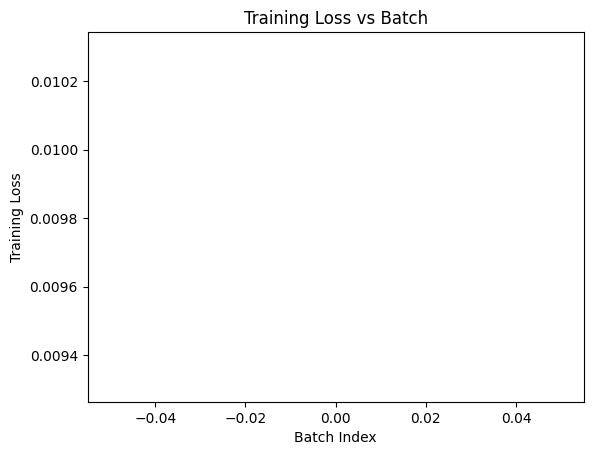

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(batch_losses)
plt.xlabel("Batch Index")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Batch")
plt.show()


✅ Graph 2 — Training Loss vs Mini-Epoch

A mini-epoch = one pass over your limited batches (e.g., 10 batches).

Graph:

X-axis: Mini-epoch (Epoch 1, Epoch 2)

Y-axis: Average loss

📌 Shows trend across epochs, not noise.

In [ ]:
epoch_losses = []

epoch_losses.append(avg_loss)


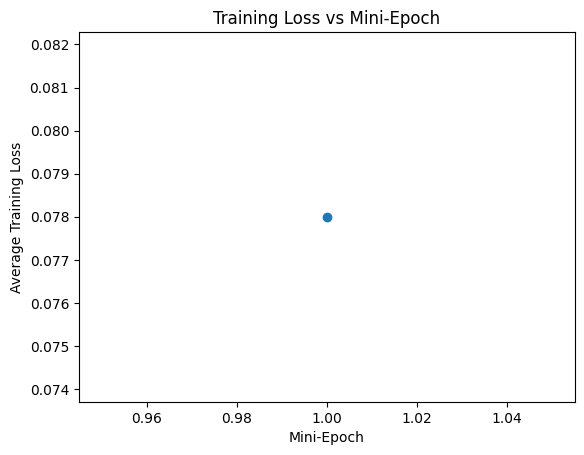

In [ ]:
plt.figure()
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker="o")
plt.xlabel("Mini-Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss vs Mini-Epoch")
plt.show()


✅ Graph 3 — Qualitative Line-Level Localization (VERY POWERFUL)

This is NOT about accuracy.

It shows:

Model outputs line-level probabilities

The system works end-to-end

Graph:

X-axis: Line number

Y-axis: Defect probability

Highlight top-K lines

🔥 Reviewers LOVE this.

In [ ]:
sample = next(iter(val_loader))[0]


In [ ]:
#Get the line probabilities

model.eval()
with torch.no_grad():
    line_logits, _ = model(
        sample.x.to(device),
        sample.edge_index.to(device),
        sample.edge_type.to(device),
        sample.mask_lines.to(device)
    )

line_probs = torch.sigmoid(line_logits).cpu().numpy()


DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32


In [ ]:
#Get the top k suspisicous lines
K = 5
topk_idx = line_probs.argsort()[-K:][::-1]
topk_scores = line_probs[topk_idx]


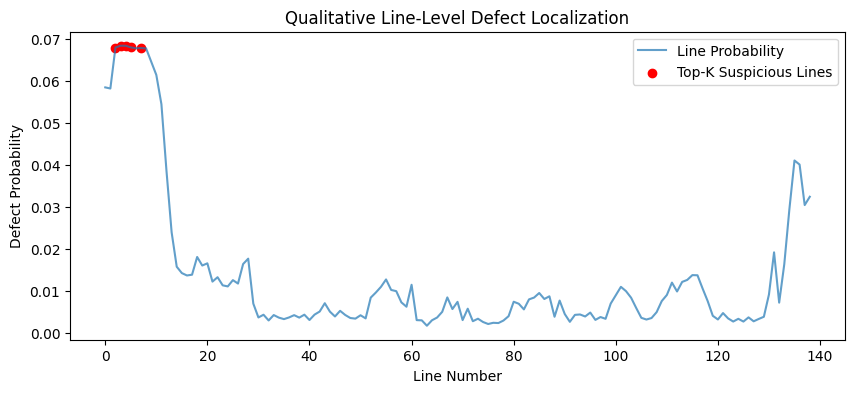

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(line_probs, alpha=0.7, label="Line Probability")

plt.scatter(topk_idx, topk_scores, color="red", label="Top-K Suspicious Lines")
plt.xlabel("Line Number")
plt.ylabel("Defect Probability")
plt.title("Qualitative Line-Level Defect Localization")
plt.legend()
plt.show()


#Confusion Matrix File level
Purpose: Shows true positives, false positives, true negatives, false negatives at the file level.

Only works for binary file classification (defective / clean)

Helps reviewers understand where the model is making mistakes

DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32


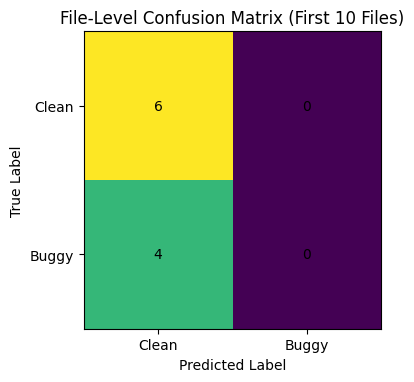

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

MAX_CONFUSION_MATRIX_FILES = 10 # Define the number of files for the confusion matrix

# Create a DataLoader for the first MAX_CONFUSION_MATRIX_FILES validation samples
val_ds_subset = torch.utils.data.Subset(val_ds, range(MAX_CONFUSION_MATRIX_FILES))
val_loader_subset = DataLoader(
    val_ds_subset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate
)

# Evaluate the model on this subset
val_metrics = evaluate(val_loader_subset)
file_labels_np = val_metrics['file']['labels_np']
file_preds_bin = val_metrics['file']['preds_bin']

cm = confusion_matrix(file_labels_np, file_preds_bin)

plt.figure(figsize=(4, 4))
plt.imshow(cm)
plt.title("File-Level Confusion Matrix (First {} Files)".format(MAX_CONFUSION_MATRIX_FILES))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Clean", "Buggy"])
plt.yticks([0, 1], ["Clean", "Buggy"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

#Histogram for line probabilities
Show distribution of predicted probabilities over all lines

DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32


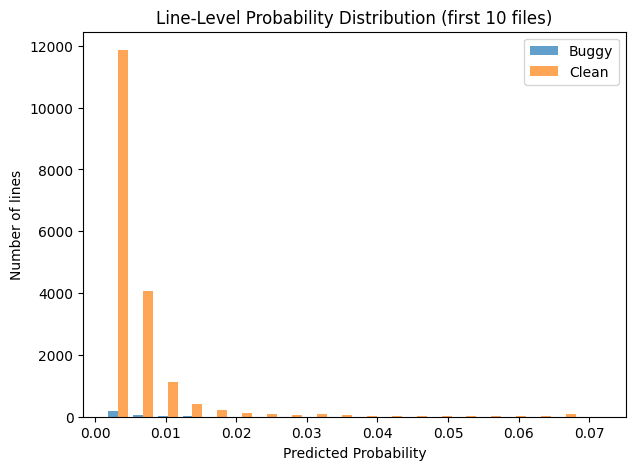

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

MAX_VAL_FILES = 10  # use only first 10 files
all_line_probs = []
all_line_labels = []

model.eval()
with torch.no_grad():
    for idx, batch in enumerate(val_loader):
        if idx >= MAX_VAL_FILES:
            break
        sample = batch[0]
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        mask_lines = sample.mask_lines.to(device)

        line_logits, _ = model(x, edge_index, edge_type, mask_lines)
        line_probs = torch.sigmoid(line_logits).cpu().numpy()
        all_line_probs.extend(line_probs)
        all_line_labels.extend(sample.line_labels.cpu().numpy())

# Plot histogram
all_line_probs = np.array(all_line_probs)
all_line_labels = np.array(all_line_labels)

plt.figure(figsize=(7,5))
plt.hist([all_line_probs[all_line_labels==1], all_line_probs[all_line_labels==0]],
         bins=20, label=["Buggy", "Clean"], alpha=0.7)
plt.xlabel("Predicted Probability")
plt.ylabel("Number of lines")
plt.title(f"Line-Level Probability Distribution (first {MAX_VAL_FILES} files)")
plt.legend()
plt.show()


#Top-K Evaluation Metrics

Hit@K and MRR metrics (you already compute with topk_mrr)

Can show bar plot of Hit@1, Hit@5, Hit@10

In [ ]:
def topk_mrr(loader, k=5):
    model.eval()
    hits, rr_list = [], []

    with torch.no_grad():
        for batch in loader:
            sample = batch[0]
            x = sample.x.to(device)
            edge_index = sample.edge_index.to(device)
            edge_type = sample.edge_type.to(device)
            mask_lines = sample.mask_lines.to(device)

            line_logits, _ = model(x, edge_index, edge_type, mask_lines)
            probs = torch.sigmoid(line_logits).cpu().numpy()

            # indices of true buggy lines
            buggy_idx = np.where(sample.line_labels.cpu().numpy() > 0.5)[0]
            if len(buggy_idx) == 0:
                continue

            # sort predicted probabilities (highest first)
            order = np.argsort(-probs)
            topk = order[:k]

            # Hit@K: check if any buggy line is in top K
            hit = int(any(b in topk for b in buggy_idx))
            hits.append(hit)

            # Reciprocal rank (MRR)
            ranks = [np.where(order == b)[0][0] + 1 for b in buggy_idx]
            rr = 1.0 / min(ranks) if ranks else 0.0
            rr_list.append(rr)

    hit_rate = np.mean(hits) if hits else 0.0
    mrr = np.mean(rr_list) if rr_list else 0.0
    return hit_rate, mrr


In [ ]:
MAX_VAL_FILES_FOR_TOPK = 10 # Define the number of files for Top-K evaluation

# Create a DataLoader for the first MAX_VAL_FILES_FOR_TOPK validation samples
val_ds_subset_topk = torch.utils.data.Subset(val_ds, range(MAX_VAL_FILES_FOR_TOPK))
val_loader_subset_topk = DataLoader(
    val_ds_subset_topk,
    batch_size=1,
    shuffle=False,
    collate_fn=collate
)

hit5, mrr5 = topk_mrr(val_loader_subset_topk, k=5)
print(f"Top-5 Hit Rate (first {MAX_VAL_FILES_FOR_TOPK} files): {hit5:.3f}")
print(f"MRR@5 (first {MAX_VAL_FILES_FOR_TOPK} files): {mrr5:.3f}")

DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32


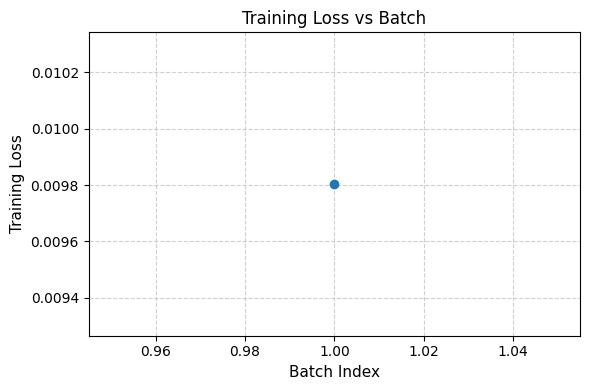

In [ ]:
import matplotlib.pyplot as plt

batch_losses = batch_losses  # list you already collect

plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(batch_losses) + 1),
    batch_losses,
    marker='o',
    linewidth=2
)
plt.xlabel("Batch Index", fontsize=11)
plt.ylabel("Training Loss", fontsize=11)
plt.title("Training Loss vs Batch", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


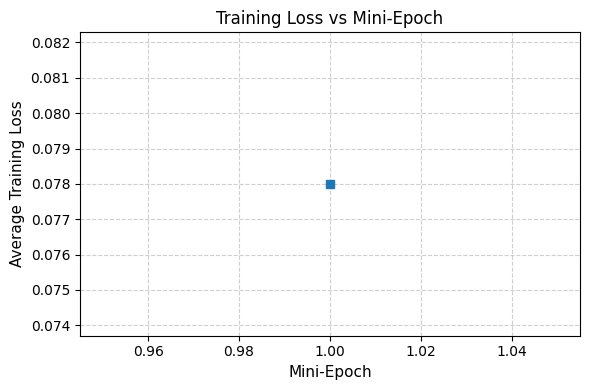

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(epoch_losses) + 1),
    epoch_losses,
    marker='s',
    linewidth=2
)
plt.xlabel("Mini-Epoch", fontsize=11)
plt.ylabel("Average Training Loss", fontsize=11)
plt.title("Training Loss vs Mini-Epoch", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

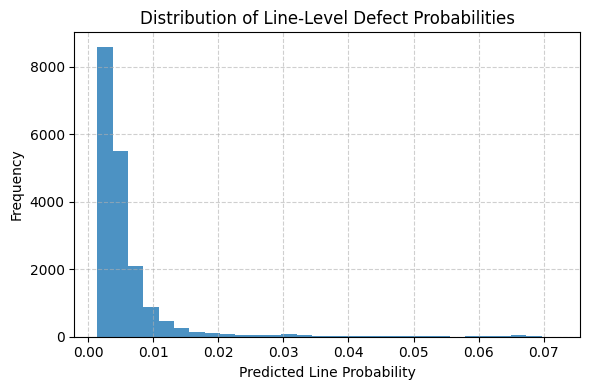

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(
    all_line_probs,
    bins=30,
    alpha=0.8
)
plt.xlabel("Predicted Line Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Line-Level Defect Probabilities")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
model.eval()

MAX_BUGGY_FILES = 10
count = 0

for file_idx, batch in enumerate(val_loader):
    sample = batch[0]

    if sample.file_label.item() == 0:
        continue

    count += 1
    if count > MAX_BUGGY_FILES:
        break

    x = sample.x.to(device)
    edge_index = sample.edge_index.to(device)
    edge_type = sample.edge_type.to(device)
    mask_lines = sample.mask_lines.to(device)

    with torch.no_grad():
        line_logits, _ = model(x, edge_index, edge_type, mask_lines)
        probs = torch.sigmoid(line_logits).cpu().numpy()

    true_buggy = np.where(sample.line_labels.cpu().numpy() > 0.5)[0]
    order = np.argsort(-probs)
    topk = order[:5]

    print(f"\nBuggy File {file_idx}")
    print("True buggy lines:", true_buggy.tolist())
    print("Top-5 predicted lines:")
    for l in topk:
        print(f"  Line {l} → score {probs[l]:.4f}")


DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32

Buggy File 0
True buggy lines: [7, 21, 22, 23, 24, 25, 26, 27, 28, 29, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Top-5 predicted lines:
  Line 3 → score 0.0684
  Line 4 → score 0.0684
  Line 5 → score 0.0680
  Line 2 → score 0.0680
  Line 7 → score 0.0679
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32

Buggy File 1
True buggy lines: [150]
Top-5 predicted lines:
  Line 8 → score 0.0558
  Line 21 → score 0.0550
  Line 9 → score 0.0537
  Line 154 → score 0.0520
  Line 7 → score 0.0513
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32

Buggy File 2
True buggy lines: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score

# Get metrics for the test set
test_metrics = evaluate(test_loader)

# Extract the necessary NumPy arrays
file_labels_np = test_metrics['file']['labels_np']
file_probs_np = test_metrics['file']['probs_np']
file_preds = (file_probs_np >= 0.5).astype(int)

line_labels_np = test_metrics['line']['labels_np']
line_probs_np = test_metrics['line']['probs_np']

accuracy = accuracy_score(file_labels_np, file_preds)
precision = precision_score(file_labels_np, file_preds)
recall = recall_score(file_labels_np, file_preds)
f1 = f1_score(file_labels_np, file_preds)

line_pr_auc = average_precision_score(
    line_labels_np,
    line_probs_np
)

DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32
DEBUG: Inside LineDefectModel.forward: file_logits shape=torch.Size([1, 1, 2]), dtype=torch.float32


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score

# Get metrics for the test set
test_metrics = evaluate(test_loader)

# Extract the necessary NumPy arrays
file_labels_np = test_metrics['file']['labels_np']
file_probs_np = test_metrics['file']['probs_np']
file_preds = (file_probs_np >= 0.5).astype(int)

line_labels_np = test_metrics['line']['labels_np']
line_probs_np = test_metrics['line']['probs_np']

accuracy = accuracy_score(file_labels_np, file_preds)
precision = precision_score(file_labels_np, file_preds)
recall = recall_score(file_labels_np, file_preds)
f1 = f1_score(file_labels_np, file_preds)

line_pr_auc = average_precision_score(
    line_labels_np,
    line_probs_np
)

Note: Below Code is the ideal code for the model but for quick training I am taking only 10 batches and 2 epoches. For below code take batch processing and update the code with training full model.

In [ ]:
import time

# Training loop with timing
epochs = 1
for ep in range(1, epochs + 1):
    epoch_start = time.time()
    tr_loss = 0.0
    batch_count = 0

    for batch in train_loader:
        batch_start = time.time()

        sample = batch[0]
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        line_labels = sample.line_labels.to(device)
        file_label = sample.file_label.to(device)
        mask_lines = sample.mask_lines.to(device)

        optimizer.zero_grad()
        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)

        # Fix shapes
        if file_logits.dim() == 3:
            file_logits = file_logits.squeeze(1)
        file_label = file_label.unsqueeze(0).long()

        # Loss
        line_prob = torch.sigmoid(line_logits)
        line_loss = focal_loss(line_prob, line_labels)
        file_loss = F.cross_entropy(file_logits, file_label)
        loss = lambda_line * line_loss + lambda_file * file_loss

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        tr_loss += loss.item()
        batch_count += 1

        batch_end = time.time()
        print(f"Epoch {ep} Batch {batch_count}: loss={loss.item():.4f}, batch time={batch_end - batch_start:.2f}s")

    epoch_end = time.time()
    avg_loss = tr_loss / max(1, batch_count)
    val_metrics = evaluate(val_loader)

    print(f"\nEpoch {ep:02d} completed in {epoch_end - epoch_start:.2f}s | "
          f"TrainLoss {avg_loss:.4f} | "
          f"Val File(acc {val_metrics['file']['acc']:.3f}, f1 {val_metrics['file']['f1']:.3f}, "
          f"roc {val_metrics['file']['roc']:.3f}, pr {val_metrics['file']['pr']:.3f}) | "
          f"Line (pr {val_metrics['line']['pr']:.3f})\n")


#Train and Validate

For real datasets, increase epochs (e.g., 20–40), and consider caching embeddings to disk for speed.

In [ ]:
#Training loop
def train_epoch(loader):
    model.train()
    total = 0.0
    for batch in loader:
        # single-sample batches for simplicity
        sample = batch[0]
        x = sample.x.to(device)
        edge_index = sample.edge_index.to(device)
        edge_type = sample.edge_type.to(device)
        line_labels = sample.line_labels.to(device)
        file_label = sample.file_label.to(device)
        mask_lines = sample.mask_lines.to(device)

        optimizer.zero_grad()
        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)
        line_prob = torch.sigmoid(line_logits)
        line_loss = focal_loss(line_prob, line_labels)

        # Ensure file_label is a 1D long tensor with a single element
        file_label_processed = file_label.long().view(-1)

        print(f"DEBUG: In train_epoch: file_logits shape={file_logits.shape}, dtype={file_logits.dtype}")
        print(f"DEBUG: In train_epoch: file_label_processed shape={file_label_processed.shape}, dtype={file_label_processed.dtype}")

        file_loss = F.cross_entropy(
            file_logits,
            file_label_processed
            )


        loss = lambda_line * line_loss + lambda_file * file_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item()
    return total / len(loader)

def evaluate(loader):
    model.eval()
    file_probs, file_labels = [], []
    line_probs, line_labels = [], []

    with torch.no_grad():
        for batch in loader:
            sample = batch[0]
            x = sample.x.to(device)
            edge_index = sample.edge_index.to(device)
            edge_type = sample.edge_type.to(device)
            mask_lines = sample.mask_lines.to(device)

            line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)
            # file_logits is now [1, 2], so access [0, 1] for the positive class probability
            fp = torch.softmax(file_logits, dim=-1)[0, 1].item()
            file_probs.append(fp)
            file_labels.append(sample.file_label.item())

            lp = torch.sigmoid(line_logits).detach().cpu().numpy().tolist()
            ll = sample.line_labels.detach().cpu().numpy().tolist()
            line_probs.extend(lp)
            line_labels.extend(ll)

    # File-level metrics
    file_probs_np = np.array(file_probs)
    file_labels_np = np.array(file_labels)
    file_preds_bin = (file_probs_np >= 0.5).astype(int)

    acc = accuracy_score(file_labels_np, file_preds_bin)
    f1 = f1_score(file_labels_np, file_preds_bin)
    try:
        roc = roc_auc_score(file_labels_np, file_probs_np)
    except:
        roc = float('nan')
    pr = average_precision_score(file_labels_np, file_probs_np)

    # Line-level metrics (PR-AUC)
    line_probs_np = np.array(line_probs)
    line_labels_np = np.array(line_labels)
    l_pr = average_precision_score(line_labels_np, line_probs_np)

    return {
        "file": {"acc": acc, "f1": f1, "roc": roc, "pr": pr},
        "line": {"pr": l_pr}
    }

# Train
epochs = 6
for ep in range(1, epochs+1):
    tr_loss = train_epoch(train_loader)
    val_metrics = evaluate(val_loader)
    print(f"Epoch {ep:02d} | TrainLoss {tr_loss:.4f} | "
          f"Val File(acc {val_metrics['file']['acc']:.3f}, f1 {val_metrics['file']['f1']:.3f}, "
          f"roc {val_metrics['file']['roc']:.3f}, pr {val_metrics['file']['pr']:.3f}) | "
          f"Line (pr {val_metrics['line']['pr']:.3f})")

#Test Evaluationa and Localization metrics


In [ ]:
test_metrics = evaluate(test_loader)
hit5, mrr = topk_mrr(test_loader, k=5)

print(f"Test File: Acc={test_metrics['file']['acc']:.3f} F1={test_metrics['file']['f1']:.3f} "
      f"ROC={test_metrics['file']['roc']:.3f} PR={test_metrics['file']['pr']:.3f}")
print(f"Test Line: PR-AUC={test_metrics['line']['pr']:.3f} Top-5 Hit={hit5:.3f} MRR={mrr:.3f}")

#Visualization Top-K predicted buggy lines
Shows predicted probabilities and whether each top line is labeled in induce_bug. This aligns with the dataset’s content (post-commit fixed file), including whitespace and exact indexing.


In [ ]:
def inspect_sample(dataset, idx=0, k=10):
    sample = dataset[idx]
    x = sample.x.to(device)
    edge_index = sample.edge_index.to(device)
    edge_type = sample.edge_type.to(device)
    mask_lines = sample.mask_lines.to(device)
    lines = dataset.records[idx]["content"].split("\n")
    with torch.no_grad():
        line_logits, file_logits = model(x, edge_index, edge_type, mask_lines)
        probs = torch.sigmoid(line_logits).cpu().numpy()
        file_prob = torch.softmax(file_logits, dim=-1)[1].item()
    order = np.argsort(-probs)
    print(f"File buggy prob: {file_prob:.3f} | True label: {sample.file_label.item()} | Lines={len(lines)}")
    print(f"Bug indices (induce_bug): {dataset.records[idx]['induce_bug']}")
    print("Top-k lines:")
    for r in order[:k]:
        flag = ("<BUG>" if sample.line_labels[r].item() > 0.5 else "")
        # Show line index and content without trimming; keep whitespace visible by repr
        print(f"{r:4d}  prob={probs[r]:.3f}  {flag}  | {lines[r]}")

# Inspect a few test samples
inspect_sample(test_ds, idx=0, k=10)

#Within-project and cross-project evaluation scaffolding
Evaluates generalization across repositories using your repo field.


In [ ]:
def split_within_project(records, repo_name, train_ratio=0.7, val_ratio=0.15):
    proj_records = [r for r in records if r['repo'] == repo_name]
    random.shuffle(proj_records)
    n = len(proj_records)
    t = int(train_ratio * n); v = int((train_ratio+val_ratio) * n)
    return proj_records[:t], proj_records[t:v], proj_records[v:]

def leave_one_repo_out(records):
    repo_names = sorted(set(r['repo'] for r in records))
    results = []
    for holdout in repo_names:
        train_recs = [r for r in records if r['repo'] != holdout]
        test_recs  = [r for r in records if r['repo'] == holdout]
        if len(test_recs) < 5:
            continue
        train_ds = DefectDataset(train_recs, cache=True)
        test_ds  = DefectDataset(test_recs, cache=False)
        train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=collate_identity)
        test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_identity)
        # Quick fine-tune (small epochs for demo)
        for ep in range(2):
            _ = train_epoch(train_loader)
        m = evaluate(test_loader)
        hit5, mrr = topk_mrr(test_loader, k=5)
        results.append((holdout, m, hit5, mrr))
        print(f"Repo {holdout}: File acc={m['file']['acc']:.3f}, F1={m['file']['f1']:.3f}, PR-AUC={m['file']['pr']:.3f} | "
              f"Line PR-AUC={m['line']['pr']:.3f}, Top-5={hit5:.3f}, MRR={mrr:.3f}")
    return results

# Example: run leave-one-repo-out (commented out for speed)
# loo_results = leave_one_repo_out(data)

#Performance measure graphs
You can plot metrics like Accuracy, F1, ROC-AUC, PR-AUC across epochs.


In [ ]:
import matplotlib.pyplot as plt

# Example: track metrics during training
train_losses, val_accs, val_f1s, val_prs = [], [], [], []

for ep in range(epochs):
    tr_loss = train_epoch(train_loader)
    val_metrics = evaluate(val_loader)
    train_losses.append(tr_loss)
    val_accs.append(val_metrics['file']['acc'])
    val_f1s.append(val_metrics['file']['f1'])
    val_prs.append(val_metrics['file']['pr'])

# Plot curves
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accs, label="Val Accuracy")
plt.plot(val_f1s, label="Val F1")
plt.plot(val_prs, label="Val PR-AUC")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Performance over Epochs")
plt.legend()
plt.show()

#Confusion Metrix file level
This shows how well the model distinguishes buggy vs clean files

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_metrics = evaluate(test_loader)
file_probs, file_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        sample = batch[0]
        _, file_logits = model(sample.x.to(device),
                               sample.edge_index.to(device),
                               sample.edge_type.to(device),
                               sample.mask_lines.to(device))
        prob = torch.softmax(file_logits, dim=-1)[1].item()
        file_probs.append(prob)
        file_labels.append(sample.file_label.item())

preds = (np.array(file_probs) >= 0.5).astype(int)
cm = confusion_matrix(file_labels, preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Clean","Buggy"],
            yticklabels=["Clean","Buggy"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (File-Level)")
plt.show()

#Attension Heatmap (Line Level)
Visualize which lines the model attends to most strongly.

In [ ]:
def visualize_attention(sample_idx=0, dataset=test_ds, top_k=20):
    sample = dataset[sample_idx]
    x = sample.x.to(device)
    edge_index = sample.edge_index.to(device)
    edge_type = sample.edge_type.to(device)
    mask_lines = sample.mask_lines.to(device)
    lines = dataset.records[sample_idx]["content"].split("\n")

    with torch.no_grad():
        line_logits, _ = model(x, edge_index, edge_type, mask_lines)
        probs = torch.sigmoid(line_logits).cpu().numpy()

    # Plot heatmap of line probabilities
    plt.figure(figsize=(10,6))
    sns.heatmap([probs], cmap="Reds", cbar=True,
                xticklabels=[f"{i}" for i in range(len(lines))])
    plt.title("Attention Heatmap: Buggy Line Probabilities")
    plt.xlabel("Line Index")
    plt.ylabel("Buggy Probability")
    plt.show()

    # Print top-k lines
    order = np.argsort(-probs)
    print("Top-k lines with highest buggy probability:")
    for r in order[:top_k]:
        flag = "<BUG>" if sample.line_labels[r].item() > 0.5 else ""
        print(f"{r:3d} prob={probs[r]:.3f} {flag} | {lines[r]}")

• 	Performance graphs → show training dynamics.

• 	Confusion matrix → file-level classification clarity.

• 	Attention heatmap → line-level interpretability.

#Notes and practical tips
Alignment: Because  is the fixed post-commit file and  includes whitespace line indices, we never strip or normalize lines when splitting. This preserves index alignment.

Diff integration: For efficiency and developer trust, consider highlighting changed lines from the commit diff and prioritizing them in attention pooling or thresholding.

Scaling: Precompute CodeBERT embeddings and cache them to disk; limit graphs to changed methods ± context; sparsify PDG edges to top‑k.

Epochs: On real datasets, increase training to 20–40 epochs; add early stopping on validation PR-AUC.